In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import torch
import torchvision
import os
import random
from PIL import Image

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
opt = keras.optimizers.Adam()
model.compile(loss=keras.losses.binary_crossentropy,optimizer=opt,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

In [ ]:
model.save('covid.h5')

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name}')
            return images
        self.images={}
        self.class_names=['normal','covid']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [ ]:
train_dirs = {
    'normal': '/content/drive/MyDrive/Colab Notebooks/cnn /Train/NORMAL',
    'covid': '/content/drive/MyDrive/Colab Notebooks/cnn /Train/COVID'
}
train_dataset=ChestXRayDataset(train_dirs, train_transform)

Found 1200 normal
Found 1200 covid


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/cnn /Train',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

Found 2400 images belonging to 2 classes.


In [ ]:
class_names=train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(24,20))
    for i, image in enumerate(images):
        plt.subplot(1,32,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        mean=np.array([0.485,0.456,0.406])
        std= np.array([0.229, 0.224, 0.225])
        image=image*std/mean
        image=np.clip(image,0.,1.)
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

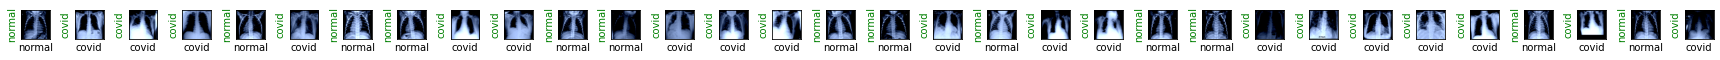

In [ ]:
images, labels =next(iter(dl_train))
show_images(images, labels, labels)

In [ ]:
train_generator.class_indices

{'COVID': 0, 'NORMAL': 1}

In [ ]:
validation_generator = test_dataset.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/cnn /Test',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 600 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps=2
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
8/8 [==============================] - 215s 25s/step - loss: 0.8154 - accuracy: 0.5625 - val_loss: 0.6892 - val_accuracy: 0.4375
Epoch 2/50
8/8 [==============================] - 171s 21s/step - loss: 0.6456 - accuracy: 0.6445 - val_loss: 0.6268 - val_accuracy: 0.8750
Epoch 3/50
8/8 [==============================] - 152s 18s/step - loss: 0.4951 - accuracy: 0.7617 - val_loss: 0.5455 - val_accuracy: 0.7812
Epoch 4/50
8/8 [==============================] - 143s 17s/step - loss: 0.4079 - accuracy: 0.8672 - val_loss: 0.4638 - val_accuracy: 0.7812
Epoch 5/50
8/8 [==============================] - 121s 15s/step - loss: 0.3502 - accuracy: 0.8477 - val_loss: 0.4469 - val_accuracy: 0.8594
Epoch 6/50
8/8 [==============================] - 104s 12s/step - loss: 0.2509 - accuracy: 0.9219 - val_loss: 0.4975 - val_accuracy: 0.8125
Epoch 7/50
8/8 [==============================] - 101s 12s/step - loss: 0.2360 - accuracy: 0.9297 - val_loss: 0.6279 - val_accuracy: 0.7500
Epoch 8/50
8/8 [====

In [ ]:
model.save('covid.h5')

In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.1558208018541336, 0.9537500143051147]

In [ ]:
model.evaluate_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.5583229064941406, 0.7916666865348816]

In [ ]:
y_actual=[]
y_test=[]

In [ ]:
from PIL import Image
for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/cnn /Test/NORMAL"):
  img = image.load_img("/content/drive/MyDrive/Colab Notebooks/cnn /Test/NORMAL/"+i, target_size = (224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/cnn /Test/COVID/"):
  img = image.load_img("/content/drive/MyDrive/Colab Notebooks/cnn /Test/COVID/"+i, target_size = (224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(0)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
import numpy as np

a=list(hist.history['accuracy'])
b=list(hist.history['val_accuracy'])
max_train=100*np.round(max(a),4)
max_validation=100*np.round(max(b),4)

#Finding max of Training accuracy
print("Maximum Training Accuracy is",max_train)

#Finding max  validation accuracy
print("Maximum Validtion Accuracy is",max_validation)

Maximum Training Accuracy is 95.30999999999999
Maximum Validtion Accuracy is 89.05999999999999


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_actual=np.array(y_actual)
y_test=np.array(y_test)

In [ ]:
cm=confusion_matrix(y_actual,y_test)

In [ ]:
cm

array([[300,   0],
       [287,  13]])

In [ ]:
import pylab as pl

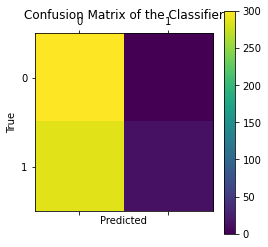

In [ ]:
cm=confusion_matrix(y_actual,y_test)
pl.matshow(cm)
pl.title('Confusion Matrix of the Classifier')
pl.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
pl.show()

In [ ]:
import seaborn as sns

In [ ]:
print(classification_report(y_actual, y_test, target_names=['COVID','NON-COVID']))

              precision    recall  f1-score   support

       COVID       0.51      1.00      0.68       300
   NON-COVID       1.00      0.04      0.08       300

    accuracy                           0.52       600
   macro avg       0.76      0.52      0.38       600
weighted avg       0.76      0.52      0.38       600



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
precision = precision_score(y_actual, y_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_actual, y_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_actual, y_test)
print('F1 score: %f' % f1)

Precision: 1.000000
Recall: 0.043333
F1 score: 0.083067
